# Big Data Final Project:

## Music Industry Analysis using Spotify


Installing Required Modules

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 41.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=abdcb5b5e232b74726add4059371767c23983ba3868fcf3db844948ff4ce7834
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


Importing Relevant Modules

In [ ]:
import pyspark
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.types as t
import pyspark.sql.functions as f
from wordcloud import WordCloud
import numpy as np

Creating Spark Configuration

In [ ]:
conf = pyspark.SparkConf()

conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','8g')
sc = pyspark.SparkContext(conf=conf)

spark = pyspark.SQLContext.getOrCreate(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading the Data and Exploratory Data Analysis

In [ ]:
spotify_df = spark.read.csv(path='/content/drive/MyDrive/BDProject-Spotify/data/charts.csv', inferSchema=True, header=True)

In [ ]:
display(spotify_df)

title,rank,date,artist,url,region,chart,trend,streams
Felices los 4,1,2017-06-01,Maluma,https://open.spot...,Argentina,top200,SAME_POSITION,246580
Me Rehúso,2,2017-06-01,Danny Ocean,https://open.spot...,Argentina,top200,SAME_POSITION,168235
Ahora Dice,3,2017-06-01,"Chris Jedi, J Bal...",https://open.spot...,Argentina,top200,SAME_POSITION,165683
Hey DJ,4,2017-06-01,"CNCO, Yandel",https://open.spot...,Argentina,top200,MOVE_UP,148050
Escápate Conmigo,5,2017-06-01,"Wisin, Ozuna",https://open.spot...,Argentina,top200,MOVE_DOWN,147183
Shape of You,6,2017-06-01,Ed Sheeran,https://open.spot...,Argentina,top200,MOVE_UP,137540
Despacito (Featur...,7,2017-06-01,Luis Fonsi,https://open.spot...,Argentina,top200,MOVE_DOWN,131376
Tu Foto,8,2017-06-01,Ozuna,https://open.spot...,Argentina,top200,SAME_POSITION,120639
El Amante,9,2017-06-01,Nicky Jam,https://open.spot...,Argentina,top200,SAME_POSITION,117467
Despacito - Remix,10,2017-06-01,"Luis Fonsi, Daddy...",https://open.spot...,Argentina,top200,SAME_POSITION,116337


In [ ]:
spotify_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- date: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: string (nullable = true)



In [ ]:
spotify_df.count()

26013872

In [ ]:
spotify_df = spotify_df.withColumn("rank", f.col("rank").cast(t.LongType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))

In [ ]:
spotify_df = spotify_df.na.drop(subset=spotify_df.columns)

In [ ]:
spotify_df.count()

20267041

In [ ]:
# the range of timeline of the data
spotify_df.agg( f.min("date").alias("Begin") , f.max("date").alias("End"))

Begin,End
2017-01-01,2021-11-30


In [ ]:
# All Top 200 Chart songs (limit)
spotify_df.select(spotify_df.columns).filter( spotify_df.chart == 'top200').show(10)

+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|               title|rank|      date|              artist|                 url|   region| chart|        trend|streams|
+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|       Felices los 4|   1|2017-06-01|              Maluma|https://open.spot...|Argentina|top200|SAME_POSITION| 246580|
|           Me Rehúso|   2|2017-06-01|         Danny Ocean|https://open.spot...|Argentina|top200|SAME_POSITION| 168235|
|          Ahora Dice|   3|2017-06-01|Chris Jedi, J Bal...|https://open.spot...|Argentina|top200|SAME_POSITION| 165683|
|              Hey DJ|   4|2017-06-01|        CNCO, Yandel|https://open.spot...|Argentina|top200|      MOVE_UP| 148050|
|    Escápate Conmigo|   5|2017-06-01|        Wisin, Ozuna|https://open.spot...|Argentina|top200|    MOVE_DOWN| 147183|
|        Shape of You|   6|2017-06-01|  

In [ ]:
spotify_df.createOrReplaceTempView("charts")

# Part 1: I am on Top but for how long?

## How many days does a song stay in Global Top50? 

Some songs appear in the Global Top50 for a few days, but some hit songs are there like ... forever.

For example, I remember Ed Sheeran's Shape of You was always in the Global Top50 list.

In [ ]:
# Read the csv file, and get the Top50 lists for each day

top50 = spotify_df.select("title", "rank", "date", "artist", "region", "chart", "streams").filter((spotify_df.chart == 'top200') & (spotify_df.rank<=50))
top50.show(truncate=False)

+-----------------------------------------------------------------------+----+----------+---------------------------------------+---------+------+-------+
|title                                                                  |rank|date      |artist                                 |region   |chart |streams|
+-----------------------------------------------------------------------+----+----------+---------------------------------------+---------+------+-------+
|Felices los 4                                                          |1   |2017-06-01|Maluma                                 |Argentina|top200|246580 |
|Me Rehúso                                                              |2   |2017-06-01|Danny Ocean                            |Argentina|top200|168235 |
|Ahora Dice                                                             |3   |2017-06-01|Chris Jedi, J Balvin, Ozuna, Arcangel  |Argentina|top200|165683 |
|Hey DJ                                                               

In [ ]:
top50_global = top50.filter(top50.region == 'Global')
n_days = top50_global.groupBy('artist', 'title').count()
n_days = n_days.withColumnRenamed('count', 'Number of days in Global Top50')
n_days.show(truncate=False)

+---------------------------------------+----------------------------------------------------------------------------------------------------------------------+------------------------------+
|artist                                 |title                                                                                                                 |Number of days in Global Top50|
+---------------------------------------+----------------------------------------------------------------------------------------------------------------------+------------------------------+
|Danny Ocean                            |Me Rehúso                                                                                                             |273                           |
|Selena Gomez                           |Fetish (feat. Gucci Mane)                                                                                             |49                            |
|Calvin Harris, Funk Wav                

In [ ]:
n_days_plt = n_days.toPandas()

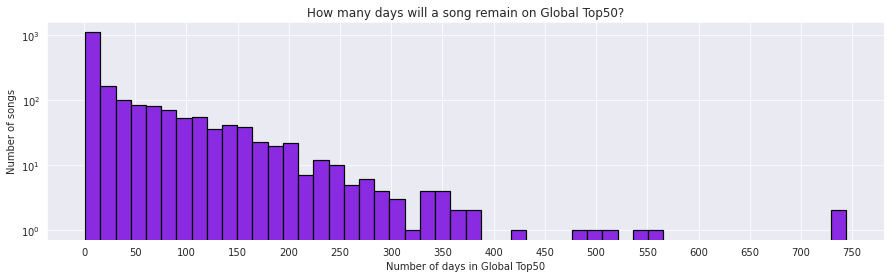

In [ ]:
plt.figure(figsize=(15,4))
plt.hist(n_days_plt['Number of days in Global Top50'], bins=50, color ='blueviolet', edgecolor='black', linewidth=1.2)
plt.yscale('log')
plt.title('How many days will a song remain on Global Top50?')
plt.xlabel('Number of days in Global Top50')
plt.ylabel('Number of songs')
plt.locator_params(axis='x', nbins=25)  
plt.show()

As we expected most songs were there just about one or two months (notice the logscale on the y-axis).

There are some songs which were on Global Top50 for over two years! Which songs were they? 

In [ ]:
n_days.orderBy(['Number of days in Global Top50'], ascending = [False]).show(truncate=False)

+----------------------------+---------------------------------------------+------------------------------+
|artist                      |title                                        |Number of days in Global Top50|
+----------------------------+---------------------------------------------+------------------------------+
|Lewis Capaldi               |Someone You Loved                            |744                           |
|The Weeknd                  |Blinding Lights                              |730                           |
|Tones And I                 |Dance Monkey                                 |559                           |
|Harry Styles                |Watermelon Sugar                             |540                           |
|Ed Sheeran                  |Shape of You                                 |510                           |
|Post Malone, Swae Lee       |Sunflower - Spider-Man: Into the Spider-Verse|492                           |
|Dua Lipa                   

We see that Lewis Capaldi's song has been in the Global Top 50 for over 2 years.

## Does the rank of that song change over time?
Consider the song Someone You Loved which stayed in Global Top50 for the longest time. We wonder how the rank of the song changed over time.

In [ ]:
top50_global.printSchema()

root
 |-- title: string (nullable = true)
 |-- rank: long (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- streams: integer (nullable = true)



In [ ]:
syl = top50_global.filter(top50_global.title == 'Someone You Loved').orderBy(['date'], ascending = [True])
syl.show(truncate=False)

+-----------------+----+----------+-------------+------+------+-------+
|title            |rank|date      |artist       |region|chart |streams|
+-----------------+----+----------+-------------+------+------+-------+
|Someone You Loved|50  |2019-03-19|Lewis Capaldi|Global|top200|1375415|
|Someone You Loved|48  |2019-03-25|Lewis Capaldi|Global|top200|1402993|
|Someone You Loved|45  |2019-03-26|Lewis Capaldi|Global|top200|1477512|
|Someone You Loved|43  |2019-03-27|Lewis Capaldi|Global|top200|1517165|
|Someone You Loved|42  |2019-03-28|Lewis Capaldi|Global|top200|1530241|
|Someone You Loved|48  |2019-04-25|Lewis Capaldi|Global|top200|1359155|
|Someone You Loved|50  |2019-04-26|Lewis Capaldi|Global|top200|1443257|
|Someone You Loved|48  |2019-04-27|Lewis Capaldi|Global|top200|1354505|
|Someone You Loved|45  |2019-04-28|Lewis Capaldi|Global|top200|1283186|
|Someone You Loved|44  |2019-04-29|Lewis Capaldi|Global|top200|1432564|
|Someone You Loved|44  |2019-04-30|Lewis Capaldi|Global|top200|1

In [ ]:
syl_plt = syl.toPandas()

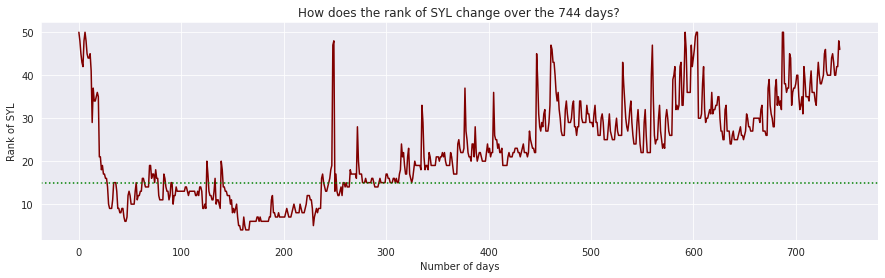

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(syl_plt['rank'], color='maroon')
plt.title('How does the rank of SYL change over the 744 days?')
plt.xlabel('Number of days')
plt.ylabel('Rank of SYL')
plt.axhline(y=15, color='g', linestyle=':')
plt.show()

At about 325-350 days (~ 1 year), the song's rank started dropping to mid-range ranks - around 25

But this plot looks kinda messy, doesn't it? Perhaps we could look at moving monthly averages for rank, instead of daily rankings.

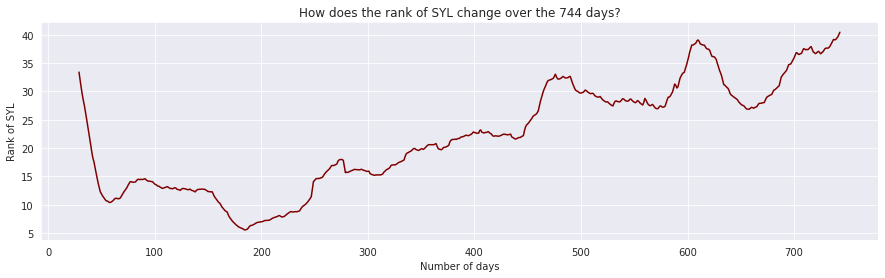

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(syl_plt['rank'].rolling(30).mean(), color='maroon')
plt.title('How does the rank of SYL change over the 744 days?')
plt.xlabel('Number of days')
plt.ylabel('Rank of SYL')
plt.show()

This is a better visualization
The song came out in 8 Nov, 2018.
Song started off with rank 33 when it was released. 
We can see that the song reached peak popularity after around 200 days of its release which is surprising. 
But never came below rank 5
And had a steady decrease after 300 days here with consistent highs and lows. 

Look for different regions, and see how that compares to global charts:

In [ ]:
top50.select('region').distinct().show()

+-------------+
|       region|
+-------------+
|     Paraguay|
|       Sweden|
|  Philippines|
|     Malaysia|
|    Singapore|
|       Turkey|
|      Germany|
|       France|
|       Greece|
|       Taiwan|
|     Slovakia|
|    Argentina|
|      Belgium|
|      Ecuador|
|      Finland|
|    Nicaragua|
|         Peru|
|       Global|
|United States|
|        Chile|
+-------------+
only showing top 20 rows



We see that there are 69 regions - we cannot do analysis on all of them so a better idea is finding the ones with the most streams - most population or rather, most number of people streaming music in that region.

In [ ]:
top50 = top50.withColumn("streams", f.col("streams").cast(t.IntegerType()))
top50

title,rank,date,artist,region,chart,streams
Felices los 4,1,2017-06-01,Maluma,Argentina,top200,246580
Me Rehúso,2,2017-06-01,Danny Ocean,Argentina,top200,168235
Ahora Dice,3,2017-06-01,"Chris Jedi, J Bal...",Argentina,top200,165683
Hey DJ,4,2017-06-01,"CNCO, Yandel",Argentina,top200,148050
Escápate Conmigo,5,2017-06-01,"Wisin, Ozuna",Argentina,top200,147183
Shape of You,6,2017-06-01,Ed Sheeran,Argentina,top200,137540
Despacito (Featur...,7,2017-06-01,Luis Fonsi,Argentina,top200,131376
Tu Foto,8,2017-06-01,Ozuna,Argentina,top200,120639
El Amante,9,2017-06-01,Nicky Jam,Argentina,top200,117467
Despacito - Remix,10,2017-06-01,"Luis Fonsi, Daddy...",Argentina,top200,116337


In [ ]:
top50.groupBy('region').sum('streams').orderBy(['sum(streams)'], ascending = [False]).show(truncate=False)

+--------------+------------+
|region        |sum(streams)|
+--------------+------------+
|Global        |207538996906|
|United States |65416907639 |
|Brazil        |26894922088 |
|Mexico        |22348452384 |
|Germany       |20268890464 |
|United Kingdom|18502301262 |
|Spain         |15162215395 |
|Italy         |13322983850 |
|France        |11360468497 |
|Argentina     |10760449008 |
|Australia     |9991130370  |
|Netherlands   |9945485532  |
|Philippines   |9877237862  |
|Chile         |9659270244  |
|Canada        |9116029685  |
|Indonesia     |8009837846  |
|Sweden        |7858625277  |
|Turkey        |6185218218  |
|Japan         |5288499482  |
|Norway        |4771171477  |
+--------------+------------+
only showing top 20 rows



We see that after Global charts, US and Brazil are the next 2 countries where most songs are streamed.

We have already seen Charts for Global, lets look at charts - United States, Brazil and Mexico and see which song stayed on Top50 chart for the longest - if it was "Someone You Loved" or not.

In [ ]:
top50_us = top50.filter(top50.region == 'United States')
n_days_us = top50_us.groupBy('artist', 'title').count()
n_days_us = n_days_us.withColumnRenamed('count', 'Number of days in US Top50')
n_days_us.show(truncate=False)

+-------------------------------------------------+----------------------------------------------------------------------------------------------------------------------+--------------------------+
|artist                                           |title                                                                                                                 |Number of days in US Top50|
+-------------------------------------------------+----------------------------------------------------------------------------------------------------------------------+--------------------------+
|Selena Gomez                                     |Fetish (feat. Gucci Mane)                                                                                             |41                        |
|Logic, Neil deGrasse Tyson                       |AfricAryaN                                                                                                            |1                         |
|Logic, Ki

In [ ]:
n_days_us.orderBy(['Number of days in US Top50'], ascending = [False]).show(truncate=False)

+---------------------+---------------------------------------------+--------------------------+
|artist               |title                                        |Number of days in US Top50|
+---------------------+---------------------------------------------+--------------------------+
|Juice WRLD           |Lucid Dreams                                 |777                       |
|Post Malone, Swae Lee|Sunflower - Spider-Man: Into the Spider-Verse|745                       |
|The Weeknd           |Blinding Lights                              |647                       |
|Post Malone          |Circles                                      |450                       |
|Post Malone, Quavo   |Congratulations                              |426                       |
|Travis Scott         |goosebumps                                   |407                       |
|Juice WRLD           |All Girls Are The Same                       |403                       |
|XXXTENTACION         |SAD!   

Top of US Charts is Lucid Dreams - not "Someone you loved" as assumed. The taste of different countries varies.

In [ ]:
ld = top50_us.filter(top50_global.title == 'Lucid Dreams').orderBy(['date'], ascending = [True])
ld_plt = ld.toPandas()

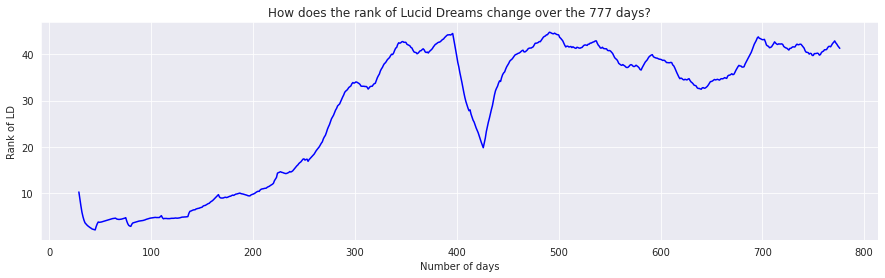

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(ld_plt['rank'].rolling(30).mean(), color='blue')
plt.title('How does the rank of Lucid Dreams change over the 777 days?')
plt.xlabel('Number of days')
plt.ylabel('Rank of LD')
plt.show()

Compared to global charts - here the song 'Lucid Dreams' started off with lower ranks and then gradually became less and less popular whereas for global charts, it peaked around the 200-day mark. This could be attributed to the fact that for global charts - the songs need to become popular for their region first and then slowly become popular globally.

The same analysis is now done for Brazil. 

In [ ]:
top50_brazil = top50.filter(top50.region == 'Brazil')
n_days_brazil = top50_brazil.groupBy('artist', 'title').count()
n_days_brazil = n_days_brazil.withColumnRenamed('count', 'Number of days in Brazil Top50')
n_days_brazil.show(truncate=False)

NameError: name 'top50' is not defined

In [ ]:
n_days_brazil.orderBy(['Number of days in Brazil Top50'], ascending = [False]).show(truncate=False)

+-------------------------------------+-----------------------------------------+------------------------------+
|artist                               |title                                    |Number of days in Brazil Top50|
+-------------------------------------+-----------------------------------------+------------------------------+
|Zé Neto & Cristiano                  |Notificação Preferida - Ao Vivo          |448                           |
|João Gustavo e Murilo, Analaga       |Lençol Dobrado                           |415                           |
|Henrique & Juliano                   |Vidinha de Balada - Ao Vivo              |408                           |
|Henrique & Juliano                   |Volta por Baixo - Ao Vivo                |408                           |
|Ed Sheeran                           |Shape of You                             |407                           |
|Henrique & Diego                     |Raspão (feat. Simone & Simaria) - Ao Vivo|396            

As expected - their top charts contain Portugese songs predominantly (since that is the national language of the country). Other than Ed Sheeran's Shape of You. Lets see the trend of its rank and see how it varies from US and Global charts.

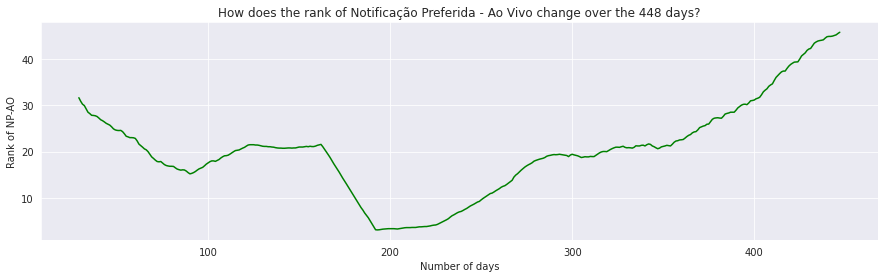

In [ ]:
np = top50_brazil.filter(top50_brazil.title == 'Notificação Preferida - Ao Vivo').orderBy(['date'], ascending = [True])
np_plt = np.toPandas()
plt.figure(figsize=(15,4))
plt.plot(np_plt['rank'].rolling(30).mean(), color='green')
plt.title('How does the rank of Notificação Preferida - Ao Vivo change over the 448 days?')
plt.xlabel('Number of days')
plt.ylabel('Rank of NP-AO')
plt.show()

This has a completely different trend as compared to the United States. The song doesn't peak early and follows a similar trend as Global charts.

Now that we have seen how songs trend in different regions, let us see how our global Top song - 'Someone you loved' is faring in the second and third highest streams top50 charts and compare that to global top50 chart

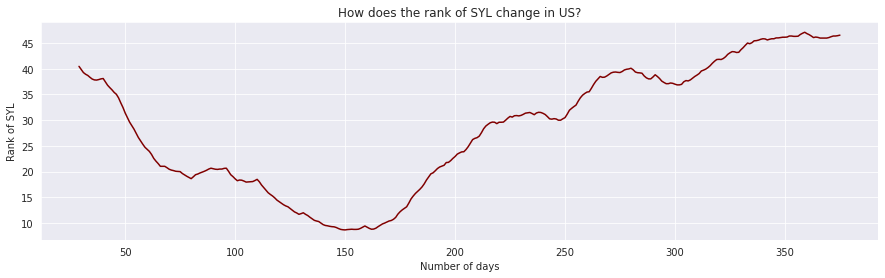

In [ ]:
syl_us= top50_us.filter(top50_us.title == 'Someone You Loved').orderBy(['date'], ascending = [True])
syl_us_plt = syl_us.toPandas()
plt.figure(figsize=(15,4))
plt.plot(syl_us_plt['rank'].rolling(30).mean(), color='maroon')
plt.title('How does the rank of SYL change in US?')
plt.xlabel('Number of days')
plt.ylabel('Rank of SYL')
plt.show()

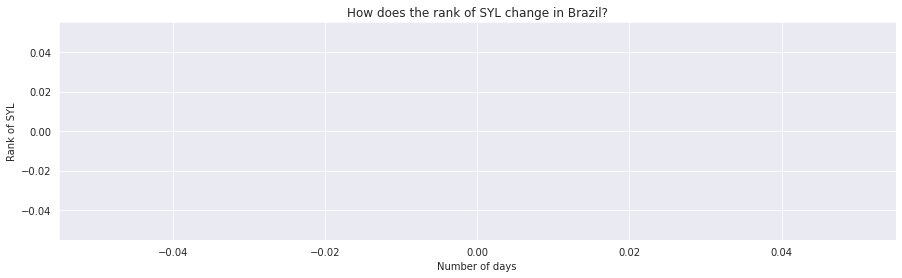

In [ ]:
syl_br= top50_brazil.filter(top50_brazil.title == 'Someone You Loved').orderBy(['date'], ascending = [True])
syl_br_plt = syl_br.toPandas()
plt.figure(figsize=(15,4))
plt.plot(syl_br_plt['rank'].rolling(30).mean(), color='maroon')
plt.title('How does the rank of SYL change in Brazil?')
plt.xlabel('Number of days')
plt.ylabel('Rank of SYL')
plt.show()

It can be seen that in the United States the song has a similar trend but it peaks around the 150-day mark, and in Brazil, the song isn't in the top 50 at all!

# Part 2: Pandemic and United States Response

Covid Pandemic hit during early 2020 and led to a period of isolation and home quarantine. During this time businesses like Spotify, Netflix and Amazon Prime boomed as people were confined to their homes. Let's try to find out the most streamed songs in the United States and their artists from the early 2020 to mid 2021 which was the peak of the pandemic.

In [ ]:
def visualize_word_counts(counts):
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='white', 
                   prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
covid_us_df = spotify_df.filter(f.col("date").between(pd.to_datetime('2020-01-01'),pd.to_datetime('2021-05-01')))
covid_us_df.createOrReplaceTempView("covid_spotify_us_df")

In [ ]:
wordcloud_us_df = spark.sql(''' SELECT title,artist,sum(streams) as total_streams from covid_spotify_us_df WHERE region='United States' GROUP BY title,artist''')
artists = " ".join(us.artist for us in wordcloud_us_df.select(f.col('artist')).collect())
titles = " ".join(us.title for us in wordcloud_us_df.select(f.col('title')).collect())

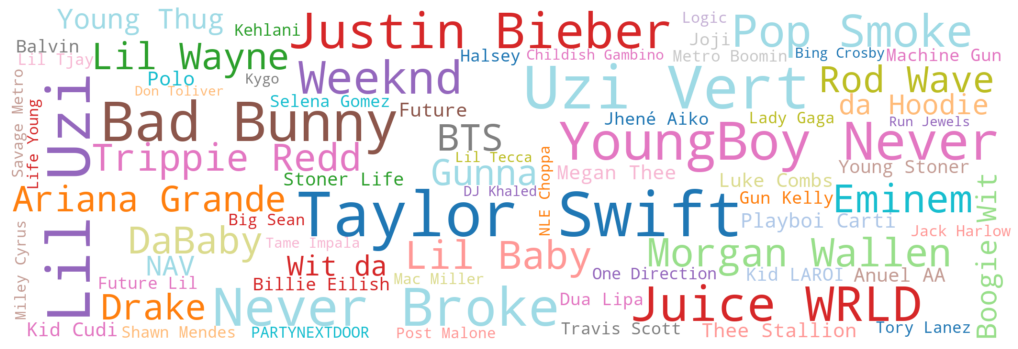

In [ ]:
visualize_word_counts(artists)

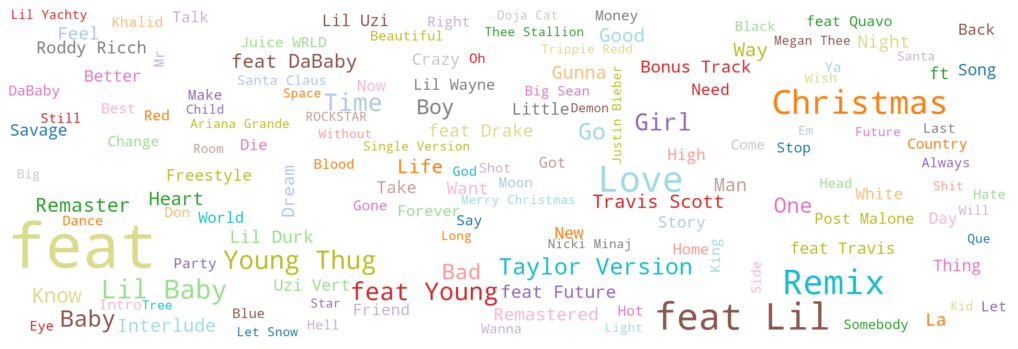

In [ ]:
visualize_word_counts(titles)

In [ ]:
spark.sql('''SELECT title,artist,sum(streams) as total_streams FROM covid_spotify_us_df WHERE region='United States' GROUP BY title,artist ORDER BY total_streams desc LIMIT 10''').show()

+--------------------+--------------+-------------+
|               title|        artist|total_streams|
+--------------------+--------------+-------------+
|             The Box|   Roddy Ricch|    441747906|
|     Blinding Lights|    The Weeknd|    409991215|
|ROCKSTAR (feat. R...|        DaBaby|    320374721|
|     Blueberry Faygo|     Lil Mosey|    317118131|
|Life Is Good (fea...|        Future|    276676856|
|             Circles|   Post Malone|    263195353|
|WAP (feat. Megan ...|       Cardi B|    256523827|
|    Watermelon Sugar|  Harry Styles|    240304241|
|Mood (feat. iann ...|      24kGoldn|    228619028|
|             ROXANNE|Arizona Zervas|    225864250|
+--------------------+--------------+-------------+



As we can see from the above The Box,Blinding Lights and ROCKSTAR were the most streamed songs in the United States during the pandemic time period. Now let's explore the popularity of these songs before pandemic,during pandemic and after pandemic.

For that we are going to analyze how the rank of these top 3 songs has changed over time in three time periods - before pandemic, during pandemic and after pandemic.

In [ ]:
top50 = spotify_df[(spotify_df['chart'] == 'top200') & (spotify_df['rank'] <= 50) & (spotify_df['region'] == 'United States')]

In [ ]:
pre_covid_df = top50.filter(f.col("date").between(pd.to_datetime('2017-06-01'),pd.to_datetime('2020-01-01')))
covid_df = top50.filter(f.col("date").between(pd.to_datetime('2020-01-01'),pd.to_datetime('2021-05-01')))
post_covid_df = top50.filter(f.col("date").between(pd.to_datetime('2021-05-01'),pd.to_datetime('2021-11-30')))

In [ ]:
box_pre_covid = pre_covid_df.filter(pre_covid_df.title=="The Box").sort(f.col("date"))
box_covid = covid_df.filter(covid_df.title=="The Box").sort(f.col("date"))
box_post_covid = post_covid_df.filter(post_covid_df.title=="The Box").sort(f.col("date"))
box_pre_covid_pd = box_pre_covid.toPandas()
box_covid_pd = box_covid.toPandas()
box_post_covid_pd = box_post_covid.toPandas()

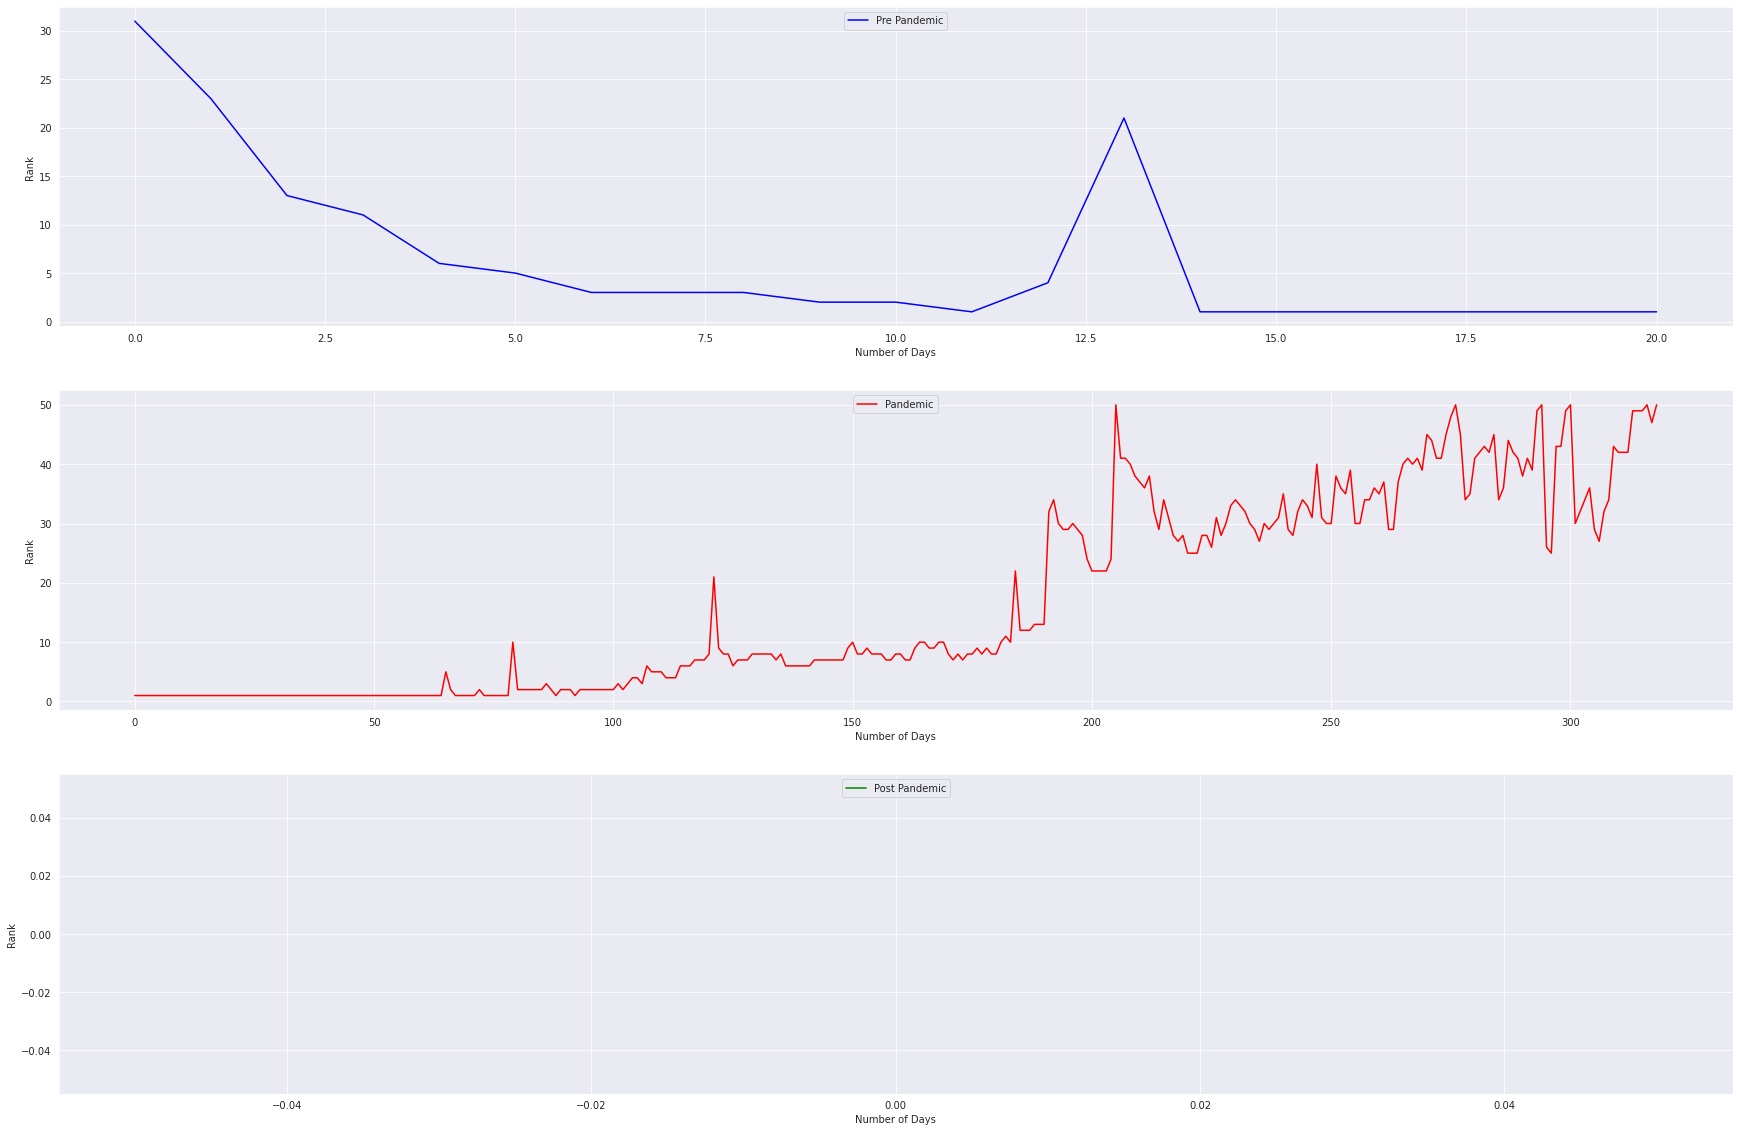

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
plt.plot(box_pre_covid_pd['rank'],color='blue',label="Pre Pandemic")
plt.xlabel("Number of Days")
plt.ylabel("Rank")
plt.legend(loc='upper center')
plt.subplot(3,1,2)
plt.plot(box_covid_pd['rank'], color='red',label="Pandemic")
plt.xlabel("Number of Days")
plt.ylabel("Rank")
plt.legend(loc='upper center')
plt.subplot(3,1,3)
plt.plot(box_post_covid_pd['rank'], color='green',label="Post Pandemic")
plt.xlabel("Number of Days")
plt.ylabel("Rank")
plt.legend(loc='upper center')
plt.show()

In [ ]:
blinding_lights_pre_covid = pre_covid_df.filter(pre_covid_df.title=="Blinding Lights").sort(f.col("date"))
blinding_lights_covid = covid_df.filter(covid_df.title=="Blinding Lights").sort(f.col("date"))
blinding_lights_post_covid = post_covid_df.filter(post_covid_df.title=="Blinding Lights").sort(f.col("date"))
blinding_lights_pre_covid_pd = blinding_lights_pre_covid.toPandas()
blinding_lights_covid_pd = blinding_lights_covid.toPandas()
blinding_lights_post_covid_pd = blinding_lights_post_covid.toPandas()

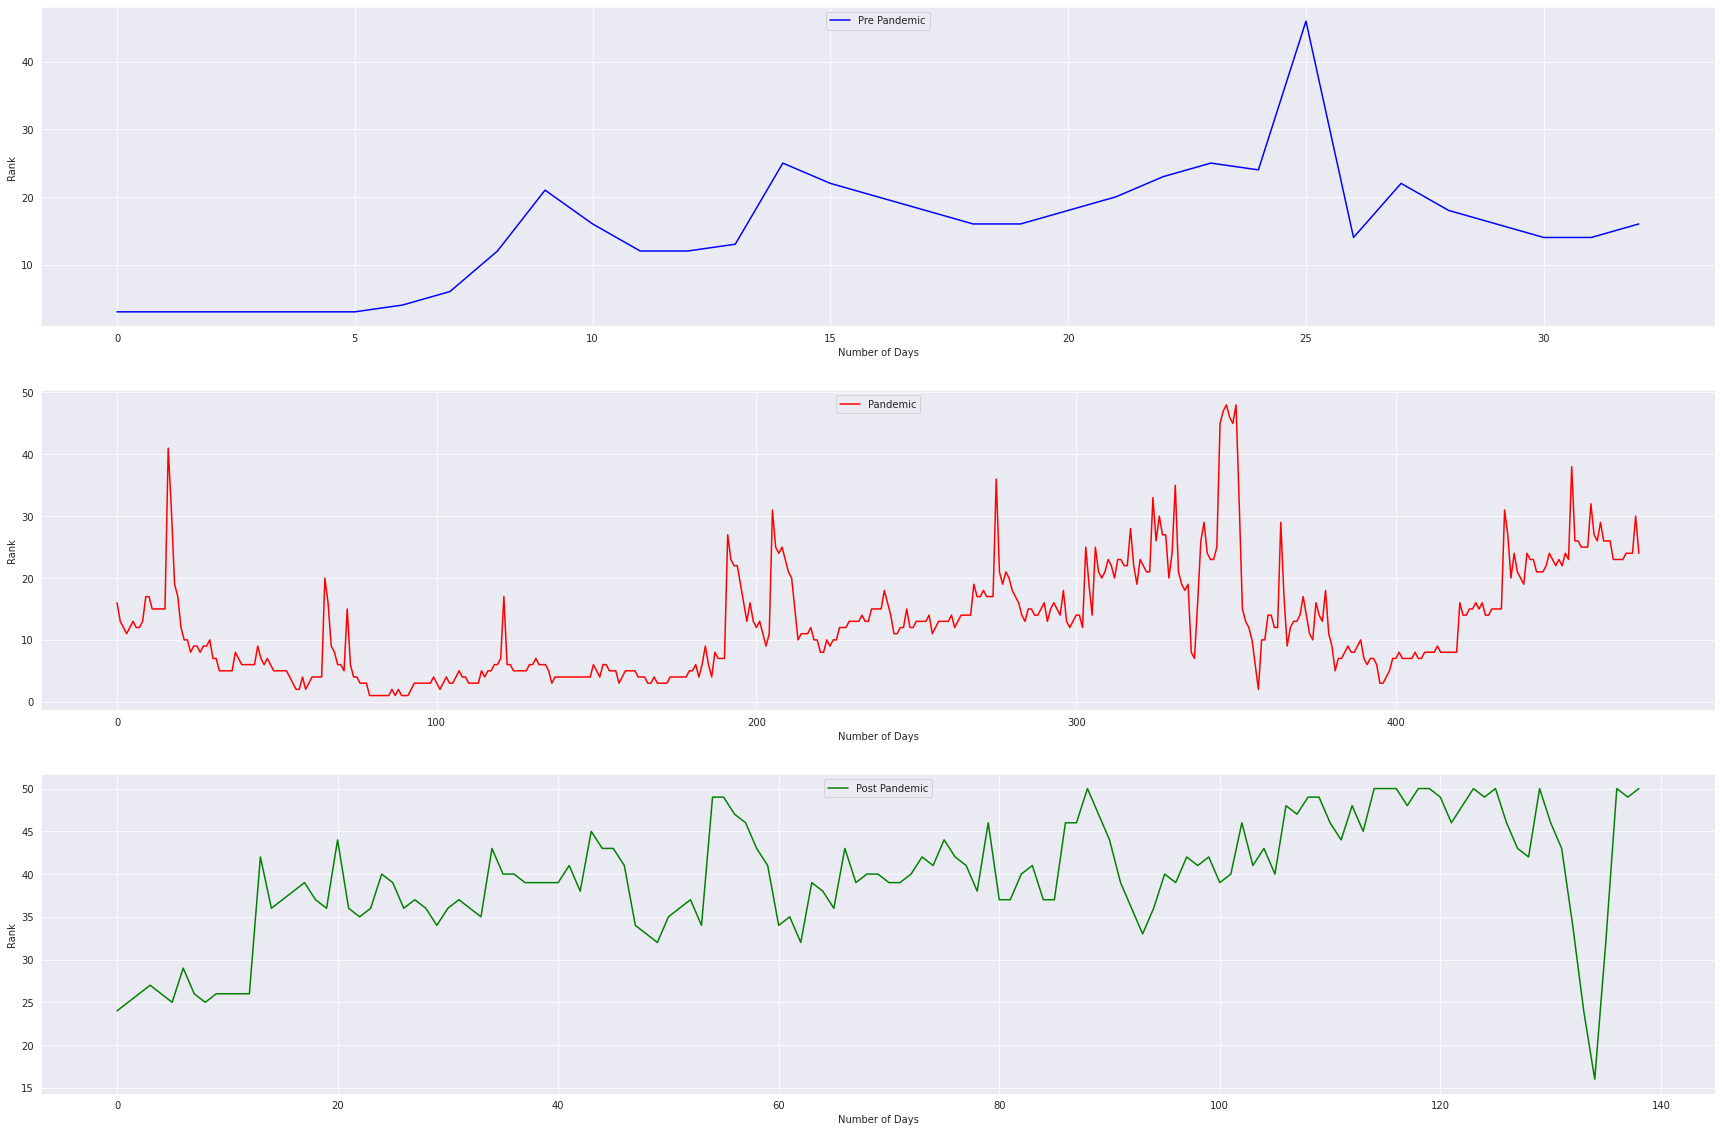

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
plt.plot(blinding_lights_pre_covid_pd['rank'] ,color='blue',label="Pre Pandemic")
plt.xlabel("Number of Days")
plt.ylabel("Rank")
plt.legend(loc='upper center')
plt.subplot(3,1,2)
plt.plot(blinding_lights_covid_pd['rank'], color='red',label="Pandemic")
plt.xlabel("Number of Days")
plt.ylabel("Rank")
plt.legend(loc='upper center')
plt.subplot(3,1,3)
plt.plot(blinding_lights_post_covid_pd['rank'], color='green',label="Post Pandemic")
plt.xlabel("Number of Days")
plt.ylabel("Rank")
plt.legend(loc='upper center')
plt.show()


As we can observe from the above line charts, The Box by Roddy Rich was a quite popular song during the pandemic as it stayed on the top charts for almost a run of first 60-70 days of the pandemic. However it quickly dropped off from the top charts and after the pandemic it's not even present in the top charts. 

Blinding Lights by The Weeknd is a different story as ever since it's release in November 2019 it's been in the top 50 charts consistently and we can notice it was highly streamed and popular song during the pandemic. 

Another takeaway from this analysis is that there is a high correlation between rank of songs and the number of times it's been streamed which is natural given that the song only gets ranked higher if it's streamed often.

The previous analysis was for the United States and we noticed that lot of the singers were rappers and highly streamed songs during this time was the rap and hip hop genre. This hints at a possible return to rap and hip hop culture during the the tough times of the pandemic in the United States.

Let's see the case globally as to which artists are dominating and where are they most popular. Initially let's compare the top 3 pandemic artists and get their global ranks in terms of number of streams.

In [ ]:
covid_df = spotify_df.filter(f.col("date").between(pd.to_datetime('2020-01-01'),pd.to_datetime('2021-05-01')))
covid_df.createOrReplaceTempView("covid_charts")
global_artist_df = spark.sql(''' SELECT artist,sum(streams) as sum_streams FROM covid_charts WHERE region='Global' GROUP BY artist''')
global_artist_df.createOrReplaceTempView("global_artists")
global_ranks = spark.sql('''SELECT artist,ROW_NUMBER() OVER (ORDER BY sum_streams DESC) Global_Rank FROM global_artists ''')
global_ranks.createOrReplaceTempView('global_ranks')
spark.sql('''select artist,Global_Rank from global_ranks WHERE artist='The Weeknd' OR artist='DaBaby' OR artist='Roddy Ricch' ''').show()

+-----------+-----------+
|     artist|Global_Rank|
+-----------+-----------+
| The Weeknd|          1|
|     DaBaby|         15|
|Roddy Ricch|         20|
+-----------+-----------+



# Part 3: What is happening around the world?

We wanted to explore the influence an artist has over the world. 
The artist of choice was Post Malone. 

Post Malone is an American rapper, singer, and songwriter. Known for his introspective songwriting and variegated vocal styles.


In [ ]:
post_malone_df = spark.sql("SELECT region,sum(streams) as sum_streams from charts where artist='Post Malone' group by region  ").filter( spotify_df.region != 'Global')


min_sum_pm = post_malone_df.agg({"sum_streams":"min"}).collect()[0]["min(sum_streams)"]
max_sum_pm = post_malone_df.agg({"sum_streams":"max"}).collect()[0]["max(sum_streams)"]

In [ ]:
diff_pm = max_sum_pm - min_sum_pm

pm_region_df = post_malone_df.withColumn("Normalized_streams",(f.col("sum_streams")-min_sum_pm)/diff_pm)

In [ ]:
import plotly as py
import plotly.graph_objs as go
pm_region_df_pd = pm_region_df.toPandas()

data = dict (
    type = 'choropleth',
    locations = pm_region_df_pd['region'],
    locationmode='country names',
    colorscale = 'Portland',
    z=pm_region_df_pd['Normalized_streams'])

In [ ]:
map = go.Figure(data=[data])
map.show()

The choropleth shows Post Malone has more influence in America which is plausible being born in American. 

Let see if region of origin affects the influence of an artist. Artist of interest is One Direction. 


One Direction, often shortened to 1D, are an English-Irish pop boy band formed in London, England in 2010.

In [ ]:
one_direction_df = spark.sql("SELECT region,sum(streams) as sum_streams from charts where artist='One Direction' group by region  ").filter( spotify_df.region != 'Global')


min_sum_od = one_direction_df.agg({"sum_streams":"min"}).collect()[0]["min(sum_streams)"]
max_sum_od = one_direction_df.agg({"sum_streams":"max"}).collect()[0]["max(sum_streams)"]

In [ ]:
diff_od = max_sum_od - min_sum_od

od_region_df = one_direction_df.withColumn("Normalized_streams",(f.col("sum_streams")-min_sum_od)/diff_od)

In [ ]:
import plotly as py
import plotly.graph_objs as go
od_region_df_pd = od_region_df.toPandas()

od_data = dict (
    type = 'choropleth',
    locations = od_region_df_pd['region'],
    locationmode='country names',
    colorscale = 'Portland',
    z=od_region_df_pd['Normalized_streams'])

In [ ]:
od_map = go.Figure(data=[od_data])
od_map.show()

Here we see a different trend here. A rather conflicting one than the previous. 

Till now the artist were producing songs in English which is an International Language. 
Lets see if language plays an important role in on the influence of an artist
We will look into BTS here. 


BTS, also known as the Bangtan Boys, is a South Korean boy band that was formed in 2010. Majority of their songs are in Korean.

In [ ]:
bts_df = spark.sql("SELECT region,sum(streams) as sum_streams from charts where artist='BTS' group by region  ").filter( spotify_df.region != 'Global')


min_sum_bts = bts_df.agg({"sum_streams":"min"}).collect()[0]["min(sum_streams)"]
max_sum_bts = bts_df.agg({"sum_streams":"max"}).collect()[0]["max(sum_streams)"]

In [ ]:
diff_bts = max_sum_bts - min_sum_bts

bts_region_df = bts_df.withColumn("Normalized_streams",(f.col("sum_streams")-min_sum_bts)/diff_bts)

In [ ]:
import plotly as py
import plotly.graph_objs as go
bts_region_df_pd = bts_region_df.toPandas()

bts_data = dict (
    type = 'choropleth',
    locations = bts_region_df_pd['region'],
    locationmode='country names',
    colorscale = 'Portland',
    z=bts_region_df_pd['Normalized_streams'])

In [ ]:
bts_map = go.Figure(data=[bts_data])
bts_map.show()

It is evident that language do not affect the fan base or the influence of an artist over the world 

# Part 4 : What is the trend of songs in the Top Charts using Machine Learning?

- Leveraged Spark ML Library to apply ML techniques. 
- One of the use cases for ML : Using Logistic Regression to do multi- class classification on the trend column.
- Trains the model based on the rank and number of streams column while using trend (MOVE_UP, MOVE_DOWN and SAME_POSITION) as a label.
- The model can be used to predict future values on the trend of a particular songs based on the rank on that date and number of times it was streamed on that day.


In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint

def mapTrendType(trend):
  if trend == "SAME_POSITION":
    return 0
  elif trend == "MOVE_UP":
    return 1
  elif trend == "MOVE_DOWN":
    return 2
def createLabeledPoints(fields):
  rank = fields[1]
  num_streams = fields[8]
  trend = mapTrendType(fields[7])
  return LabeledPoint(trend, np.array([rank,num_streams]))

In [ ]:
trend_df = spark.sql(''' SELECT * FROM charts WHERE trend='SAME_POSITION' OR trend='MOVE_UP' OR trend='MOVE_DOWN' ''')

In [ ]:
train, test = trend_df.randomSplit([0.7, 0.3], seed = 2018)

In [ ]:
spotify_train_rdd = train.rdd
train_data = spotify_train_rdd.map(createLabeledPoints)

In [ ]:
model = LogisticRegressionWithLBFGS.train(train_data,iterations=10,numClasses=3)

In [ ]:
model.save(sc,"/junk/pythonLogisticRegressionWithLBFGSModel")
#model = LogisticRegressionModel.load(sc, "/junk/pythonLogisticRegressionWithLBFGSModel")

With the now trained model we can predict the trend of an artist based on number of streams and rank of an artist in the future. Let's assume that on Christmas day Mariah Carey is on rank 3 with number of streams as 200000 as her song "All I want for Christmas is you " is a really famous holiday song. We expect it to move up in the charts for that day.

In [ ]:
trends = ["SAME_POSITION","MOVE_UP","MOVE_DOWN"]

In [ ]:
spark.sql(''' SELECT artist,rank,streams from charts where artist='Mariah Carey' and date='2020-12-25' and region='India' ''').show()

+------------+----+-------+
|      artist|rank|streams|
+------------+----+-------+
|Mariah Carey|  63|  68087|
+------------+----+-------+



In [ ]:
trends[model.predict([63,68087])]

'MOVE_DOWN'

However as we see above in the Christmas of 2020 during the pandemic in India there was not much of an increase in the trend and it actually went down which makes some sense as Christmas is not a predominantly Indian festival.

In [ ]:
spark.sql(''' SELECT artist,rank,streams from charts where artist='Mariah Carey' and date='2020-12-25' and region='United States' ''').show()

+------------+----+-------+
|      artist|rank|streams|
+------------+----+-------+
|Mariah Carey|   4|3489570|
|Mariah Carey|  53| 940594|
|Mariah Carey| 124| 562490|
|Mariah Carey| 151| 435020|
|Mariah Carey| 196| 336878|
+------------+----+-------+



In [ ]:
trends[model.predict([4,3489570])]

'SAME_POSITION'

We can incorporate region into the prediction as we notice that trend depends on the region too.